In [1]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rcParams['figure.figsize'] = [16, 56]
from plot_utils import *

# Timeline

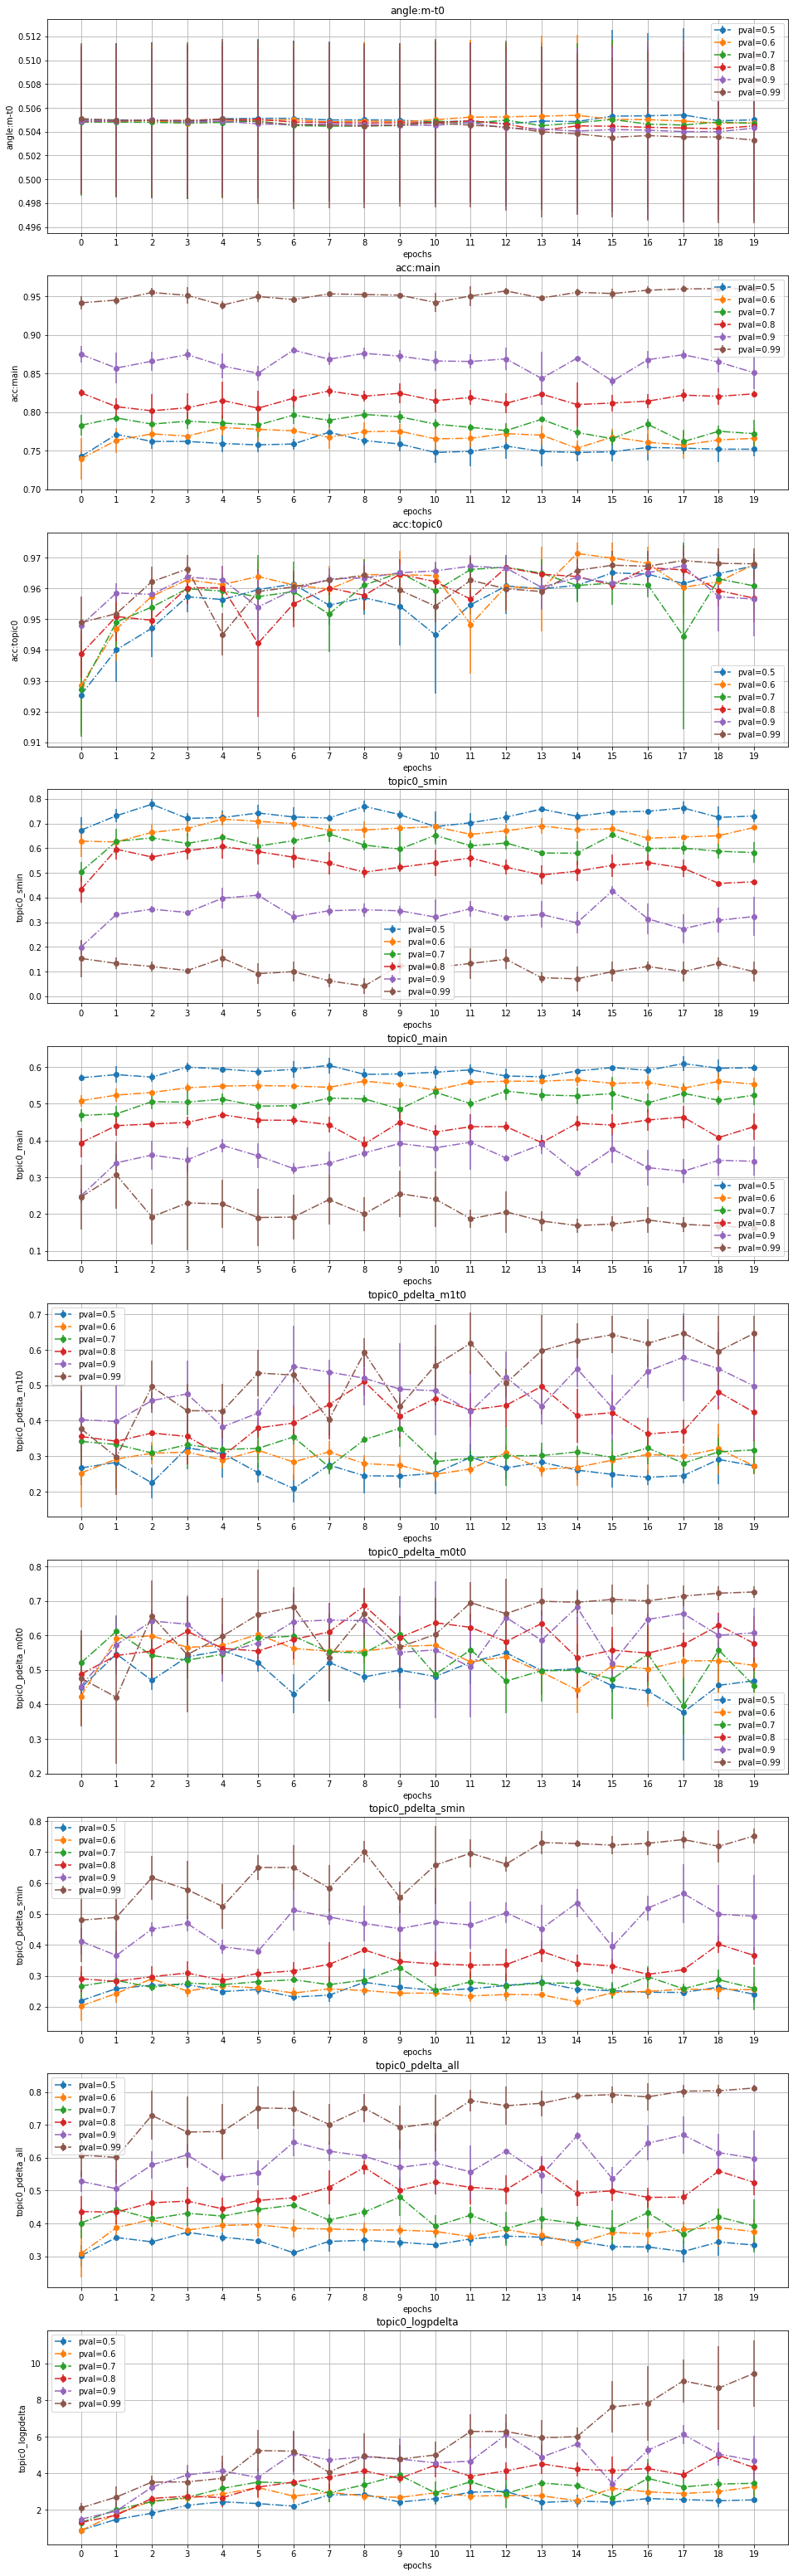

In [2]:
run_list=[1,2,3]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta_m1t0",
                    "topic0_pdelta_m0t0",
                    "topic0_pdelta_smin",
                    "topic0_pdelta_all",
                    "topic0_logpdelta",
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
h=0
e=20
s=10000
neg1_flip_method="remove_negation"
all_result_dict = get_all_result_timeline(run_list=run_list,
                                      pval_list=pval_list,
                                      fname_pattern="nlp_logs/pt.rel.model_type({}).neg1_fmethod({}).lt({}).dropout_rate({}).l2({}).noise({}).hlayer({}).sample({}).epoch({}).pval({}).rnum({})/probe_metric_list.json".format(
                                                                              model_type,
                                                                              neg1_flip_method,
                                                                              lt,
                                                                              drate,
                                                                              l2,
                                                                              n,
                                                                              h,
                                                                              s,
                                                                              e,
                                                                              "{}",
                                                                              "{}",
                                      )
)
plot_one_timeline(pval_list,all_result_dict,plot_item_list)

# Variation with Samples

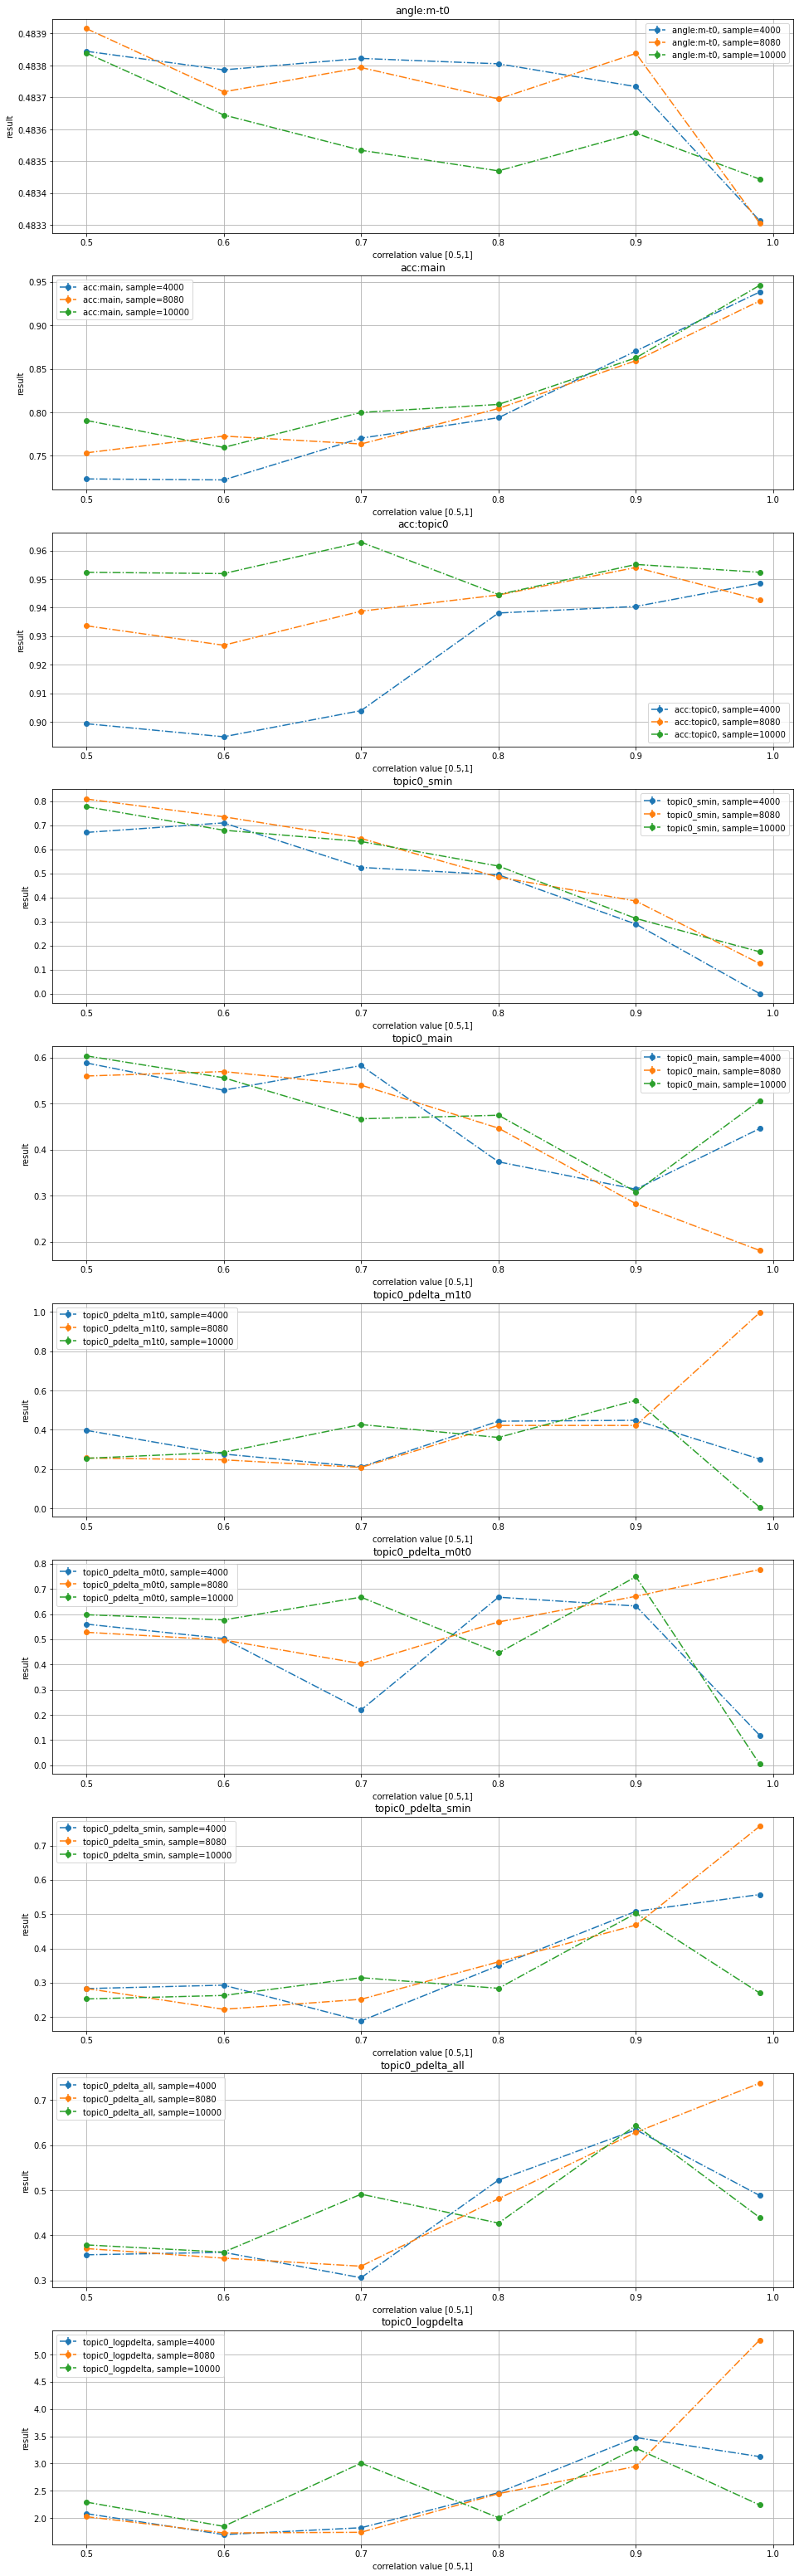

'\nAs the correlation is increasing the number of samples of minoroty group is also decreasing.\nSo, is the average minority group accuracy estimate good enough?\n'

In [14]:
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta_m1t0",
                    "topic0_pdelta_m0t0",
                    "topic0_pdelta_smin",
                    "topic0_pdelta_all",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
neg1_flip_method="remove_negation"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
h=0
e=3
#10000,20000
for s in [4000,8080,10000,]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          enum=e,
                                          fname_pattern="nlp_logs/pt.rel.model_type({}).neg1_fmethod({}).lt({}).dropout_rate({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  model_type,
                                                                                  neg1_flip_method,
                                                                                  lt,
                                                                                  drate,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", sample={}".format(s))


plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''

# Variation with Parameters

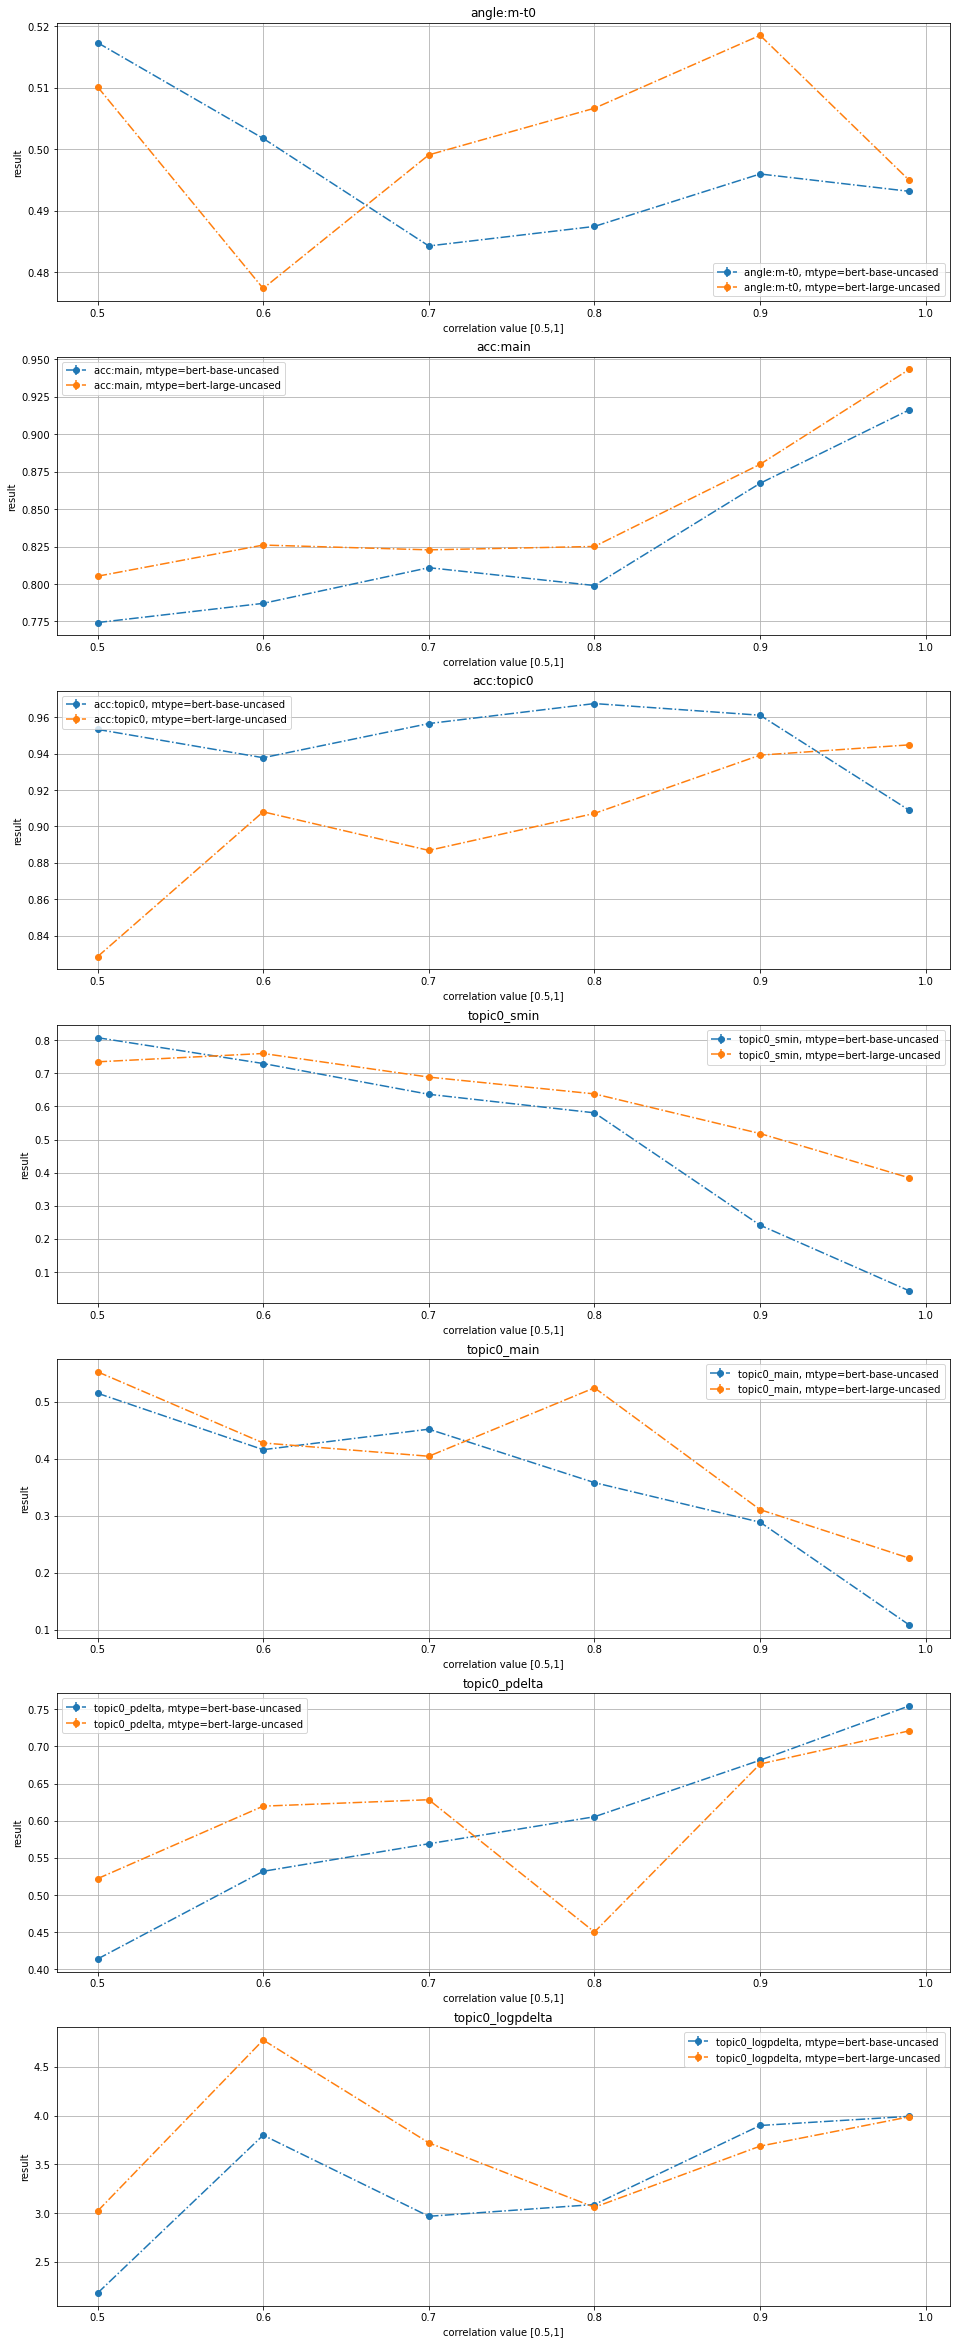

'\nAs the correlation is increasing the number of samples of minoroty group is also decreasing.\nSo, is the average minority group accuracy estimate good enough?\n'

In [15]:
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
h=0
e=3
s=10000
for model_type in ["bert-base-uncased","bert-large-uncased"]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          enum=e,
                                          fname_pattern="nlp_logs/pt.rel.model_type({}).lt({}).dropout_rate({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  model_type,
                                                                                  lt,
                                                                                  drate,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", mtype={}".format(model_type))


plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''

# Variation with noise

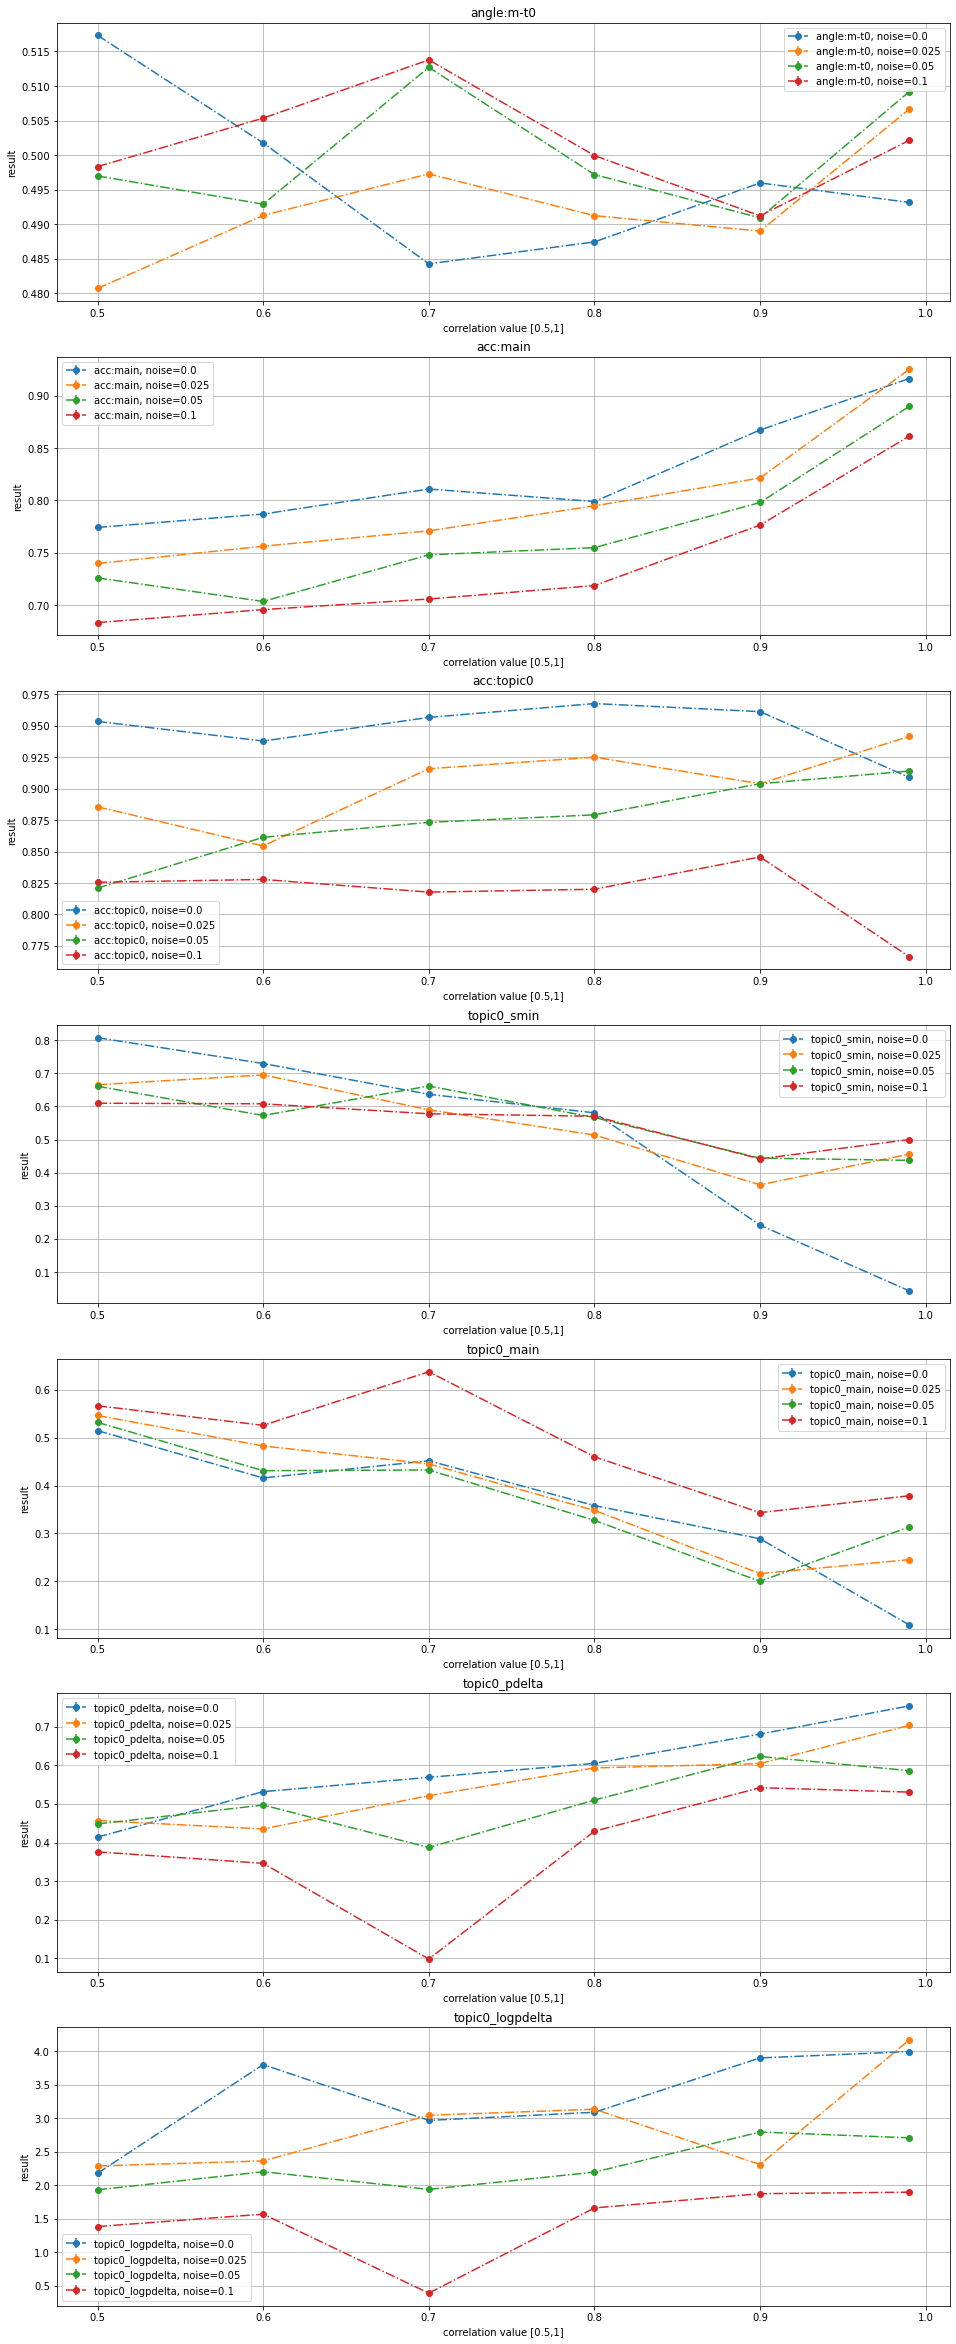

'\nAs the correlation is increasing the number of samples of minoroty group is also decreasing.\nSo, is the average minority group accuracy estimate good enough?\n'

In [16]:
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
h=0
e=3
s=10000
for n in [0.0,0.025,0.05,0.1]:
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          enum=e,
                                          fname_pattern="nlp_logs/pt.rel.model_type({}).lt({}).dropout_rate({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  model_type,
                                                                                  lt,
                                                                                  drate,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", noise={}".format(n))


plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''

# Variation with epochs

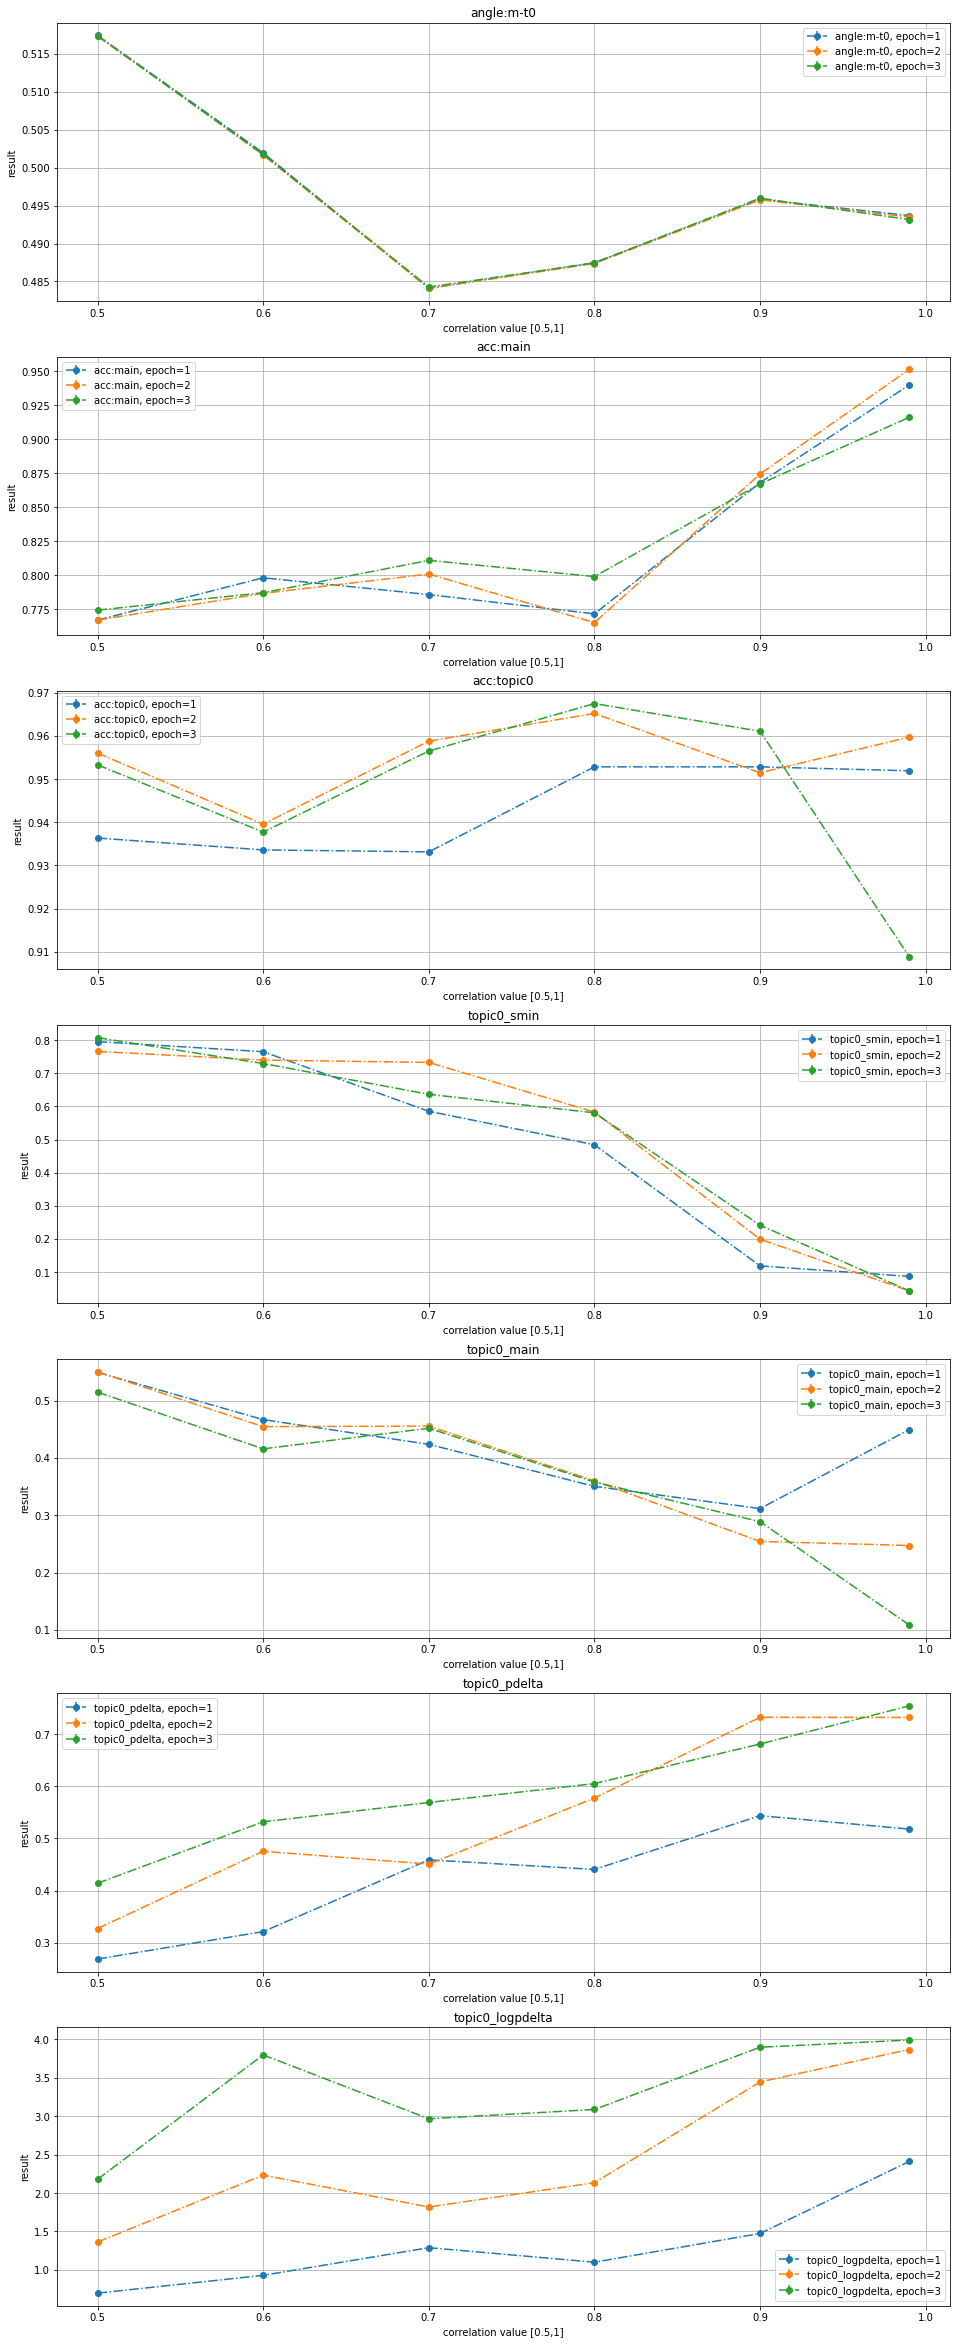

'\nAs the correlation is increasing the number of samples of minoroty group is also decreasing.\nSo, is the average minority group accuracy estimate good enough?\n'

In [12]:
run_list=[0,]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]
plot_item_list = [
                    "angle:m-t0",
                    "acc:main",
                    "acc:topic0",
                    "topic0_smin",
                    "topic0_main",
                    "topic0_pdelta",
                    "topic0_logpdelta"
]


ax=None

#Other hyperparam
model_type="bert-base-uncased"
lt="x_entropy"
drate=0.0
l2=0.0
hretrain="no_warm_encoder"
d="non_causal"
n=0.0
h=0
e=3
s=10000
for enum in [1,2,3]:
    assert enum<=e,"ONly have limited data"
    all_result_dict = get_all_result_dict(run_list=run_list,
                                          pval_list=pval_list,
                                          enum=enum,
                                          fname_pattern="nlp_logs/pt.rel.model_type({}).lt({}).dropout_rate({}).l2({}).hretrain({}).d({}).n({}).h({}).s({}).e({}).p({}).r({})/probe_metric_list.json".format(
                                                                                  model_type,
                                                                                  lt,
                                                                                  drate,
                                                                                  l2,
                                                                                  hretrain,
                                                                                  d,
                                                                                  n,
                                                                                  h,
                                                                                  s,
                                                                                  e,
                                                                                  "{}",
                                                                                  "{}",
                                          )
    )
#     print(all_result_dict)
    ax = plot_all_results(ax,pval_list,all_result_dict,plot_item_list,extra_label=", epoch={}".format(enum))


plt.show()


'''
As the correlation is increasing the number of samples of minoroty group is also decreasing.
So, is the average minority group accuracy estimate good enough?
'''